# Introduction

This notebook is tackling the [Titanic Challenge](https://www.kaggle.com/c/titanic) assignment from Kaggle

You can find the data and more information on the hyperlink above. 

**Objective:** predicting whether or not a passenger survived based on attributes such as age and sex.

In [62]:
# import libraries
import numpy as np
import pandas as pd

# plotting libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")

## Loading Data and EDA

In [63]:
train = pd.read_csv(r"C:\Users\tiger\Documents\GitHub\ML-Basics\Classification\Data\Titanic\train.csv")
test = pd.read_csv(r"C:\Users\tiger\Documents\GitHub\ML-Basics\Classification\Data\Titanic\test.csv")

train.head(10)

In [64]:
train.shape

(891, 12)

In [65]:
test.shape

(418, 11)

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [67]:
test.info() # we can see that Survived is the column we want to predict

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


From info we can see that **Age, Cabin,** and **Embarked** has Null values. 

- Lets delete attribute **Cabin** entirely since over 70% is null data.
- Lets replave null values in **Age** with the median value.
- **Name** and **Ticket** are tricky to convert into useful numbers. So we will ignores those for now.

In [69]:
train.describe()
df_train = train.drop(['Cabin', 'Name', 'Ticket'], axis=1)
df_test = test.drop(['Cabin', 'Name', 'Ticket'], axis=1)
df_Survived = train['Survived'].copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


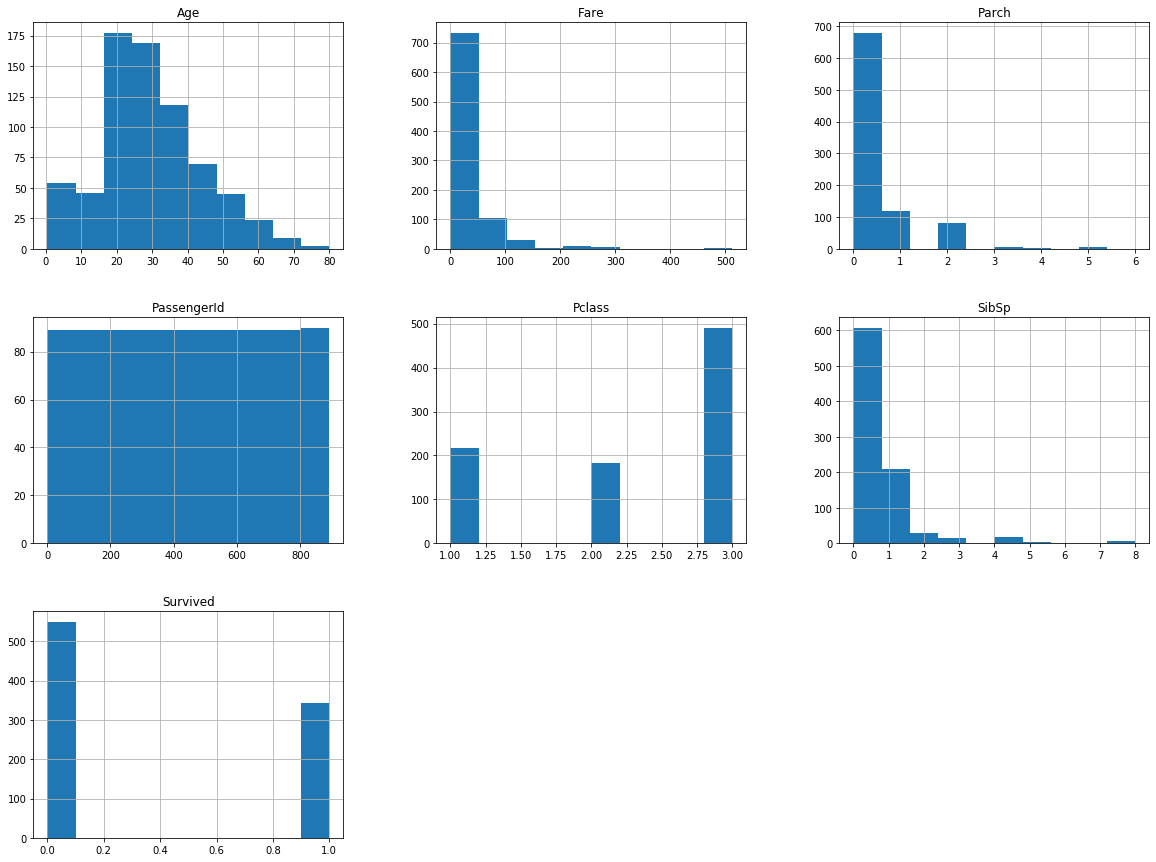

In [70]:
df_train.hist(figsize=(20,15))
plt.show()

lets build a pipeline with:
  - SimpleImputer to fill in Null values with its median
  - OneHotEncoder for embarked

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


num_attributes = ["Age", "SibSp", "Parch", "Fare"]
cat_attributes = ["Embarked"]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('std_scaler', StandardScaler()),
])


Now lets try to make a custom transformer for Embarked. So we can fit the most common letter into NaN instances.

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

# create a new class for the purpose described above
class MostFrequentStrImputer(BaseEstimator, TransformerMixin):
    
    # Probably no need for extra paramater hence ski init function
    # def __init__(): # no *args or **kwargs
    
    # we want fit to find the most frequent string here
    # lets use for loop to go through dataset X and retuen 
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    
    # fill na with most_frequent_
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [73]:
cat_pipeline = Pipeline([
        ("imputer", MostFrequentStrImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [74]:
# Build a full pipeline with column transformer

pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes), 
])

df_prepared = pipeline.fit_transform(df_train)

In [75]:
df_prepared

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [76]:
df_prepared.shape

(891, 7)

In [77]:
df_Survived.shape

(891,)

looks good since we now have 7 columns as expected. Two for **Sex** and three for **Embarked**. Now lets move on to Model Selection

## Model Selection

In [81]:
# import some models you like
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
svm = SVC(gamma='auto')
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42)

In [83]:
estimators = [lr, svm, rf, xgb]
for e in estimators:
    e.fit(df_prepared, df_Survived)

In [90]:
# train on 5-fold cross validation scores helper function
def display_scores(clf):
    s = cross_val_score(clf, df_prepared, df_Survived, cv=10)
    print(s.mean())

In [91]:
for i in estimators:
    display_scores(i)

0.6836630348428102
0.7196061741005562
0.6915423901940756
0.700554988083078
